## Prepare Notebook

# Geo-Level Bayesian Hierarchical Media Mix Modeling: A simulation in PyMC

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Synthetic Data

In [2]:
seed = sum(map(ord, "test"))
rng = np.random.default_rng(seed)

G = 5

date = pd.date_range(start="01-03-2020", end="01-04-2022", freq="W-MON")

n_obs = date.shape[0]

idx = np.linspace(start=0, stop=n_obs - 1, num=n_obs)

h = 1.41 * np.cos(2 * np.pi * (idx - 12) / 52)[..., None]

u_g = np.ones(G)
v_g = rng.normal(loc=0, scale=1, size=(n_obs, G))
rho_g = rng.uniform(low=0.1, high=0.9, size=(1, G))

x_g = u_g + rho_g * h + (np.sqrt(1 - rho_g**2) * v_g)
x_g = np.where(x_g < 0, 0, x_g)


w_z = rng.normal(loc=0, scale=1, size=(n_obs, G))
rho_z = rng.uniform(low=0.1, high=0.9, size=(1, G))
z_g = rho_z * h + (np.sqrt(1 - rho_z**2) * w_z)


In [5]:
# true parameters from Table 1
alpha_true = 0.5
K_true = 2
S_true = 3
L_true = 4
beta_true = 2
tau_true = 4
gamma_true = 2
kappa_true = 0.1
eta_true = 0.1
xi_true = 0.1
sigma_true = 0.2


def geometric_adstock_vectorized(x, alpha, l_max: int = 4):
    """Vectorized geometric adstock transformation."""
    cycles = [
        at.concatenate(tensor_list=[at.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = at.stack(cycles)
    x_cycle = at.transpose(x=x_cycle, axes=[1, 2, 0])
    w = at.as_tensor_variable([at.power(alpha, i) for i in range(l_max)])
    w = at.transpose(w)[None, ...]
    # w / at.sum(w, axis=2, keepdims=True)
    return at.sum(at.mul(x_cycle, w), axis=2)


def hill(x, k, s):
    return 1 / (1 + (x / k) ** (-s))


x_g_star = geometric_adstock_vectorized(x=x_g, alpha=alpha_true, l_max=L_true)
x_g_transformed = hill(x=x_g_star, k=K_true, s=S_true).eval()

tau_g = rng.normal(loc=tau_true, scale=kappa_true, size=G)
beta_g = rng.normal(loc=beta_true, scale=eta_true, size=G)
gamma_g = rng.normal(loc=gamma_true, scale=xi_true, size=G)
epsilon_g = rng.normal(loc=0, scale=sigma_true, size=(n_obs, G))

y_g = (
    tau_g[None, ...]
    + beta_g[None, ...] * x_g_transformed
    + gamma_g[None, ...] * z_g
    + epsilon_g
)


In [42]:
wide_data_df = pd.concat(
    [
        pd.DataFrame(data={"date": date}),
        pd.DataFrame(data=y_g, columns=[f"y_{i}" for i in range(G)]),
        pd.DataFrame(data=x_g, columns=[f"x_{i}" for i in range(G)]),
        pd.DataFrame(data=z_g, columns=[f"z_{i}" for i in range(G)]),
    ],
    axis=1,
)

wide_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    105 non-null    datetime64[ns]
 1   y_0     105 non-null    float64       
 2   y_1     105 non-null    float64       
 3   y_2     105 non-null    float64       
 4   y_3     105 non-null    float64       
 5   y_4     105 non-null    float64       
 6   x_0     105 non-null    float64       
 7   x_1     105 non-null    float64       
 8   x_2     105 non-null    float64       
 9   x_3     105 non-null    float64       
 10  x_4     105 non-null    float64       
 11  z_0     105 non-null    float64       
 12  z_1     105 non-null    float64       
 13  z_2     105 non-null    float64       
 14  z_3     105 non-null    float64       
 15  z_4     105 non-null    float64       
dtypes: datetime64[ns](1), float64(15)
memory usage: 13.2 KB


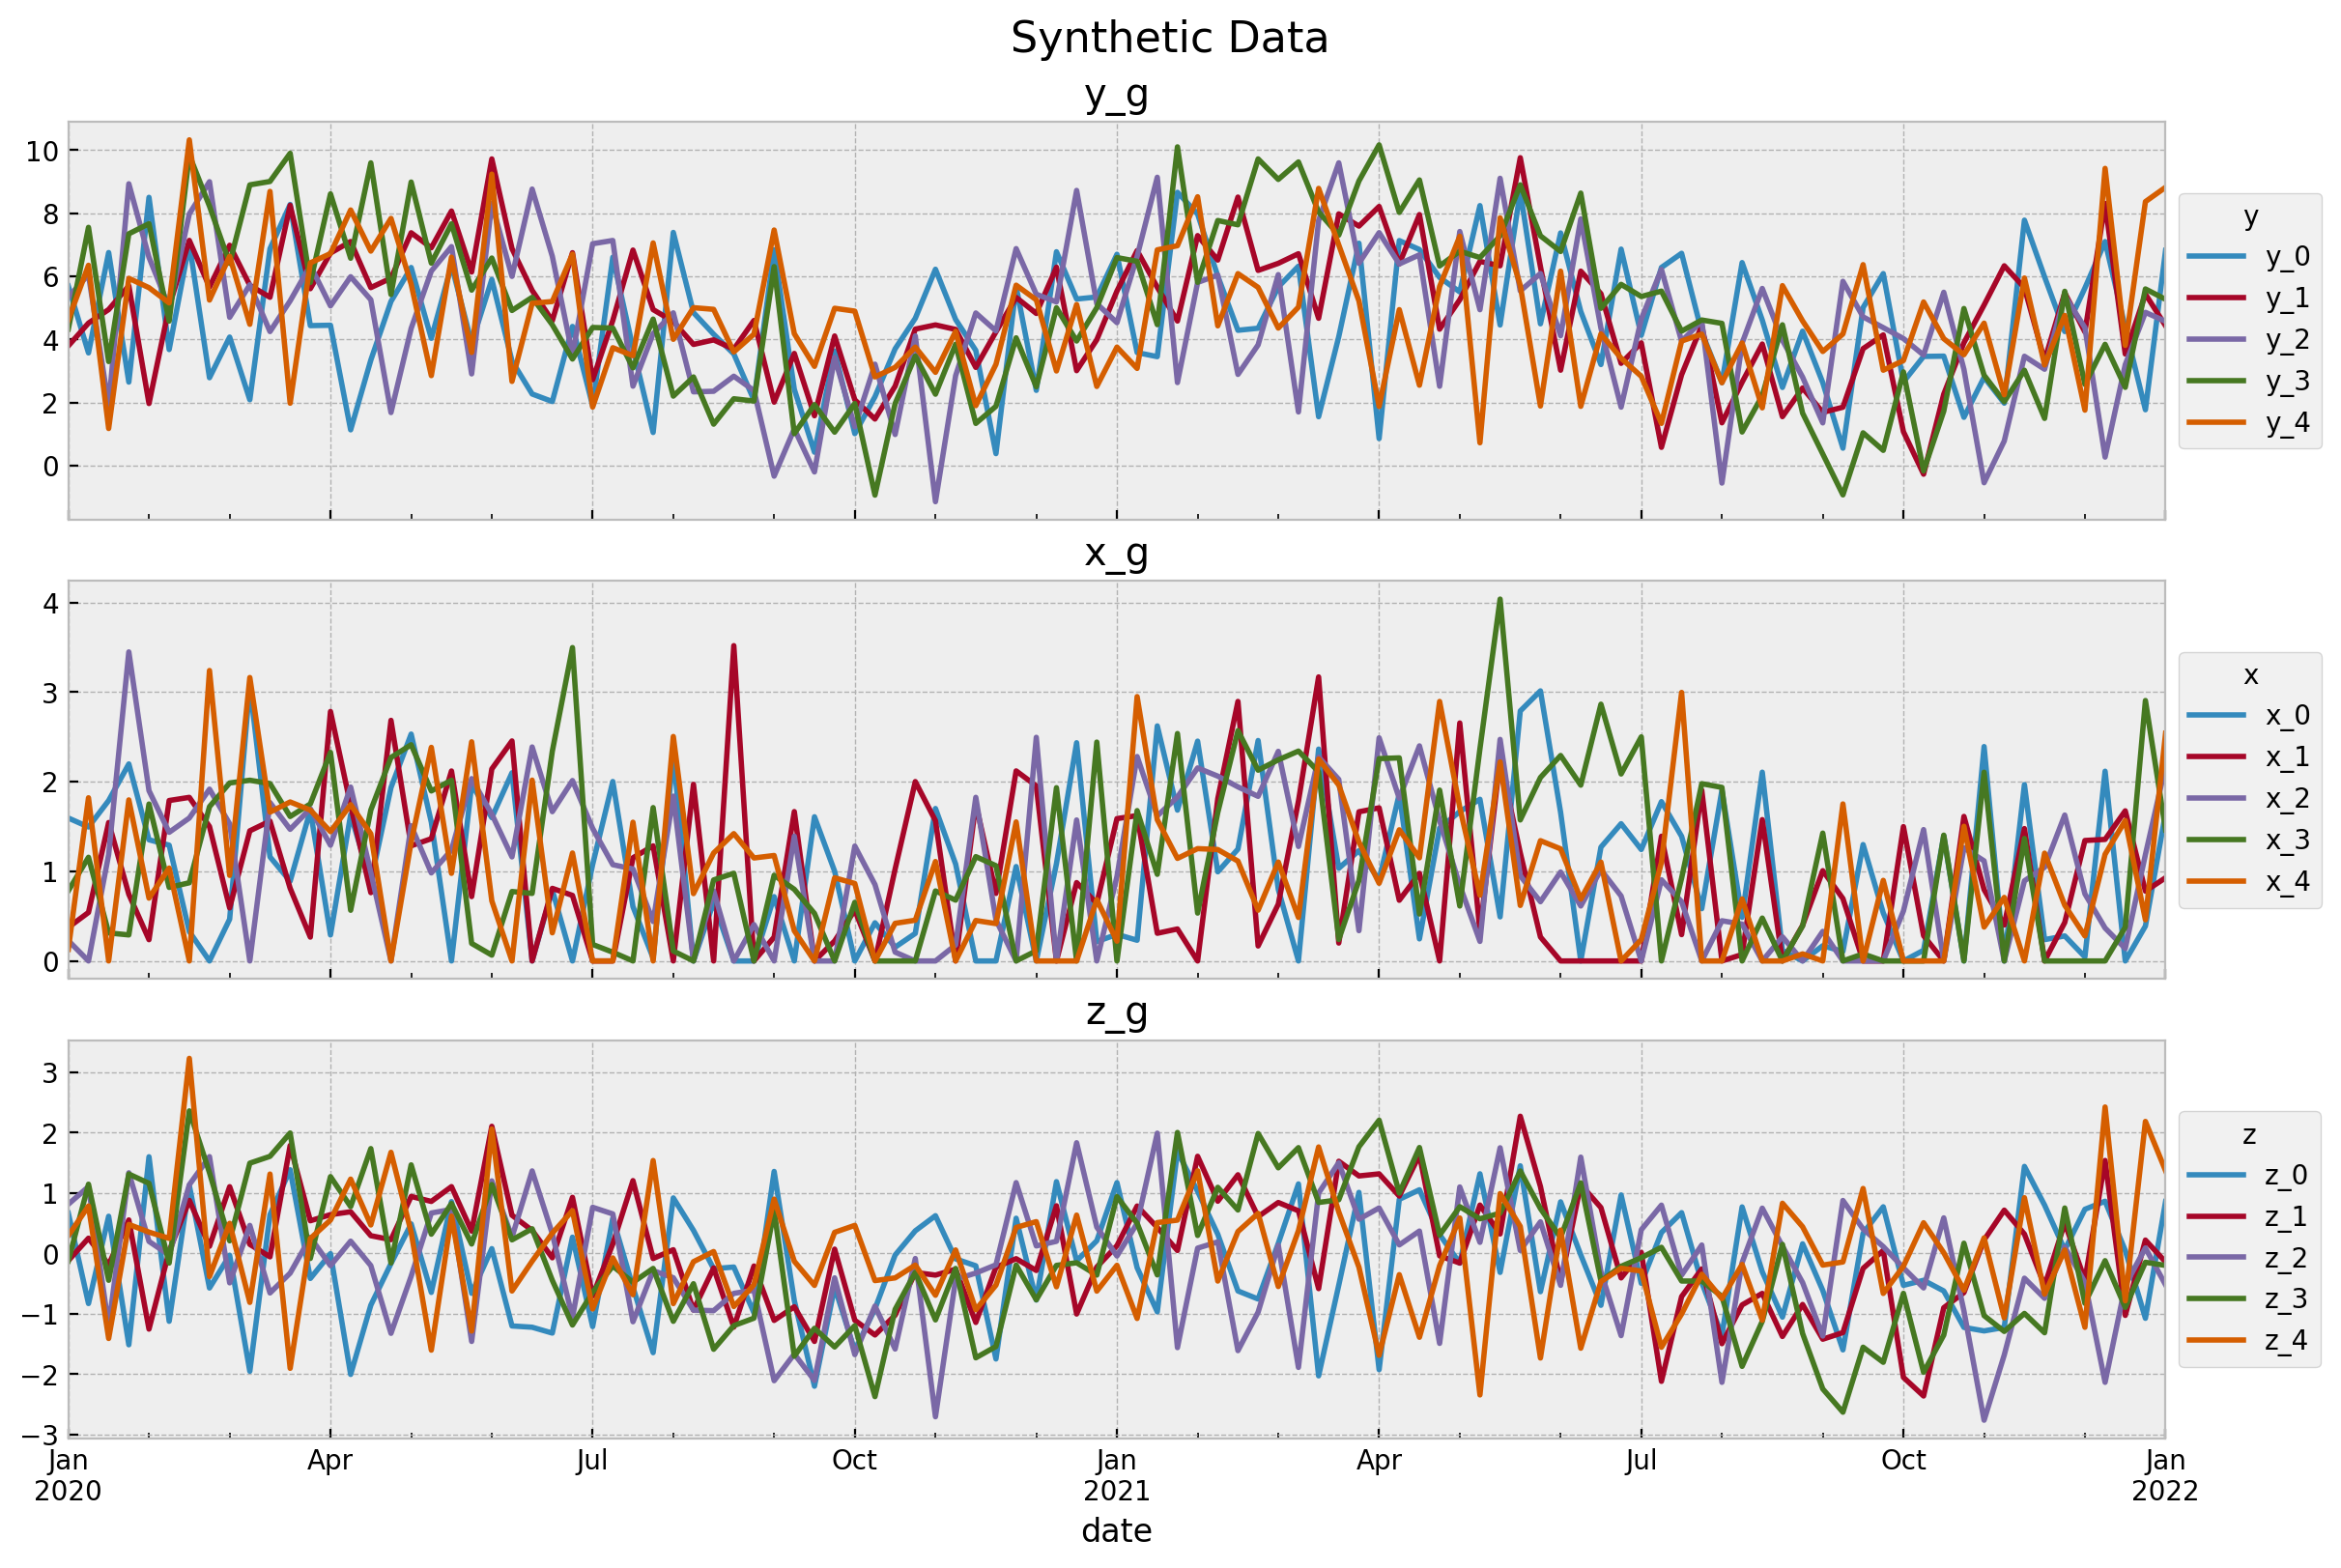

In [43]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, var in enumerate(["y", "x", "z"]):
    ax = axes[i]
    wide_data_df.filter(regex=f"(date|{var}_)").set_index("date").plot(ax=ax)
    ax.legend(title=var, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=f"{var}_g")

fig.suptitle("Synthetic Data", fontsize=16)

In [44]:
wide_data_df

,date,y_0,y_1,y_2,y_3,y_4,x_0,x_1,x_2,x_3,x_4,z_0,z_1,z_2,z_3,z_4
0,2020-01-06,5.693305,3.800061,5.341897,4.333746,4.625638,1.594960,0.374218,0.227099,0.783145,0.129593,0.664122,-0.121187,0.812607,-0.126627,0.292214
1,2020-01-13,3.576404,4.521690,6.060451,7.554379,6.352436,1.494800,0.541382,0.000000,1.157070,1.820973,-0.831060,0.250557,1.103790,1.144062,0.782978
2,2020-01-20,6.756093,4.950129,1.898167,3.302782,1.181076,1.790017,1.544568,1.188550,0.312703,0.000000,0.613720,-0.187376,-1.207350,-0.446380,-1.409586
3,2020-01-27,2.651099,5.701889,8.934297,7.349650,5.939271,2.198227,0.743725,3.448424,0.290670,1.797252,-1.514010,0.552295,1.333068,1.312176,0.478584
4,2020-02-03,8.505076,1.972375,6.605732,7.670301,5.642314,1.352116,0.237435,1.900138,1.751144,0.700766,1.598194,-1.254107,0.197493,1.158642,0.350995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2021-12-06,5.631956,4.238492,4.375604,2.579668,1.763026,0.044964,1.344086,0.748503,0.000000,0.278838,0.729131,-0.443675,-0.481057,-0.827639,-1.224428
101,2021-12-13,7.102997,8.311941,0.275264,3.849389,9.422534,2.117246,1.356284,0.367243,0.000000,1.190113,0.861932,1.536665,-2.135190,-0.121616,2.421532
102,2021-12-20,4.383959,3.541502,3.204243,2.485476,3.813909,0.000000,1.675210,0.139237,0.376540,1.566298,0.046266,-1.027860,-0.528020,-0.896019,-0.786283
103,2021-12-27,1.775210,5.439995,4.861432,5.602597,8.368355,0.389337,0.779164,1.187243,2.905942,0.458939,-1.075552,0.219161,0.089051,-0.148421,2.182729
